In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

## NLP Imports
import nltk
from nltk import FreqDist,word_tokenize,regexp_tokenize,TweetTokenizer
from nltk.corpus import stopwords
import string

from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,GridSearchCV

import warnings 
warnings.filterwarnings('always')#filterwarnings('ignore')


In [2]:
data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding= 'latin-1')
data

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
data['tweet_text'].isna().sum()

1

In [5]:
data[data['tweet_text'].isnull()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,No emotion toward brand or product


In [6]:
data.drop(6, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

In [7]:
print(data.isna().sum())

tweet_text                                               0
emotion_in_tweet_is_directed_at                       5801
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


In [8]:
data['emotion_in_tweet_is_directed_at'].value_counts(normalize=True)

iPad                               0.287451
Apple                              0.200851
iPad or iPhone App                 0.142814
Google                             0.130659
iPhone                             0.090246
Other Google product or service    0.089031
Android App                        0.024613
Android                            0.023701
Other Apple product or service     0.010635
Name: emotion_in_tweet_is_directed_at, dtype: float64

In [9]:
# change column to product because it make more sense

data.rename(columns={"emotion_in_tweet_is_directed_at": "product",
                     "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

In [10]:
# see what products are getting tweeted at the most, for just columns 
# with known data

df_product = data['product']
def view_uncleaned(data):
    products = data.value_counts()
    return pd.DataFrame({'Count of Tweets':products,
                  '% of Tweets':products/len(data)*100}).round(2)
view_uncleaned(df_product)

,Count of Tweets,% of Tweets
iPad,946,10.40
Apple,661,7.27
iPad or iPhone App,470,5.17
Google,430,4.73
iPhone,297,3.27
Other Google product or service,293,3.22
Android App,81,0.89
Android,78,0.86
Other Apple product or service,35,0.38


In [11]:
# see data that 
df_emotion = data['emotion']
view_uncleaned(df_emotion)

,Count of Tweets,% of Tweets
No emotion toward brand or product,5388,59.26
Positive emotion,2978,32.75
Negative emotion,570,6.27
I can't tell,156,1.72


In [12]:
# Since "I cant tell" group as it is, is not helpful for the business problem 
# I choose to combine it with the no emotion group since they are the most similar

data['emotion'].replace("I can't tell", "No emotion toward brand or product", inplace=True)
data['emotion'].value_counts()

No emotion toward brand or product    5544
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

In [13]:
#make only two columns to troubleshoot what is going wrong



#data['emotion'][:2000].replace("No emotion toward brand or product", "Positive emotion", inplace=True)
#data['emotion'].value_counts()

In [14]:
#make only two columns to troubleshoot what is going wrong

#data['emotion'][2000:10000].replace("No emotion toward brand or product", "Negative emotion", inplace=True)
#data['emotion'].value_counts()

#### At first glance we notice:
- The data is is missing about 2/3 of the values of what product is being tweeted about(`emotion_in_tweet_is_directed_at`)
- The majority of the tweets have no emotion followed by positive emotion. The count of negative emotion tweets is far behind them both. The data is unbalanced and this will effect the model if not delt with.
- Tweets that fall under the `I can't tell` sediment are not helpful in answering the the business question. I combined that group with the No Emotions group since, they are the most similar & relateable.

In [15]:
# take a closer look into the missing product rows

product_missing = data[data['product'].isnull()]
product_missing.head()

,tweet_text,product,emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
15,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
31,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
32,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
33,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion toward brand or product


In [16]:
# majority are neutral emotion, suggests that the tweet is a coversation and not so much geared towards a company

product_missing['emotion'].value_counts()

No emotion toward brand or product    5444
Positive emotion                       306
Negative emotion                        51
Name: emotion, dtype: int64

Since by far the majority of NaN rows are assigned to `Neutral` emotion. I am going to leave it for now and come back to later on in analysis during further cleaning. 

/Users/rachelfein/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


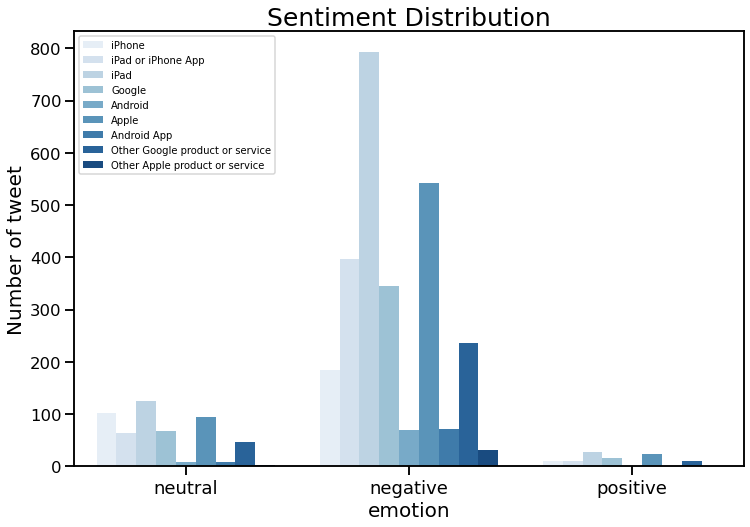

In [17]:
labels = ['neutral','negative','positive']
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(data['emotion'], hue=data['product'], palette='Blues')
plt.title('Sentiment Distribution', fontsize=25)
ax.set_xticklabels(labels, fontsize=18)
plt.xlabel('emotion',fontsize=20)
plt.ylabel('Number of tweet',fontsize=20)
plt.legend(loc=2, prop={'size': 10})
plt.show()

## Data Preparation
- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?

Code for data cleaning

In [18]:
# we need to map the target since everything will need to be an int. when modeling

def map_target(x):
    if x == 'Positive emotion':
        return 2
    elif x == 'Negative emotion':
        return 1
    else:
        return 0

In [19]:
data['target'] = data['emotion'].apply(map_target)
data['target'].value_counts(dropna=False,normalize=True)

0    0.609767
2    0.327541
1    0.062692
Name: target, dtype: float64

In [20]:
# split the data at start to aviod data leakage

target = 'target'

y = data[target]
X = data.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [21]:
# out of curiosity we can look at ther % of each sediment in the 
# train and test data as a reference to how well divided the data is 

print("Train percent vaccinated:", y_train.value_counts(normalize=True))
print('-------------')
print("Test percent vaccinated: ", y_test.value_counts(normalize=True))

Train percent vaccinated: 0    0.609767
2    0.327614
1    0.062619
Name: target, dtype: float64
-------------
Test percent vaccinated:  0    0.609767
2    0.327321
1    0.062912
Name: target, dtype: float64


In [22]:
from nltk import word_tokenize
import nltk
nltk.download('punkt')
# Hide warnings
import warnings
warnings.filterwarnings('ignore')
import re

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rachelfein/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
tweet_sample = X_train["tweet_text"].iloc[1]
tweet_sample

'Whoa - line for ipad2 is 3blks long!!! #apple #Austin #SXSW'

In [24]:
from nltk import TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=False,)
token_sample = tokenizer.tokenize(tweet_sample)
token_sample
#df['Reviews']=[" ".join(review) for review in df['Reviews'].values]

['whoa',
 '-',
 'line',
 'for',
 'ipad',
 '2',
 'is',
 '3blks',
 'long',
 '!',
 '!',
 '!',
 '#apple',
 '#austin',
 '#sxsw']

In [25]:
X_train["tweet_text"]=X_train["tweet_text"].apply(tokenizer.tokenize)

In [26]:
shortword = re.compile(r'\W*\b\w{1,3}\b')
#altered_string = re.sub(',', '', my_string)
#print('My new string: {}'.format(altered_string))
#find_commas = re.compile()

def cleaner(tweet):
    
    tweet = re.sub(r'@[A-Za-z0-9]+','', str(tweet)) # removes @
    tweet = re.sub(r'#', '', str(tweet)) # removes hashtag
    tweet = re.sub(r'RT[\s]+','', str(tweet)) # removes RT
    tweet = re.sub(r'https?:\/\/\S+', '', tweet) # remove hyperlink in tweet
    tweet = re.sub(r'[^\w\s]', '', tweet) # removes punctuations
    tweet = re.sub(r',', '', str(tweet)) # remove commas 
    tweet = shortword.sub('', tweet)
    

    return tweet

X_train["tweet_text"] = X_train["tweet_text"].apply(cleaner)

In [27]:
X_train["tweet_text"] = X_train["tweet_text"].str.lower()

In [28]:
#X_train["tweet_text"] = X_train["tweet_text"].replace(',',"")

In [29]:
X_train

,tweet_text,product,emotion
2689,schemes done with ipad shape lesson sxsw,NaN,No emotion toward brand or product
4535,whoa line ipad 3blks long apple austin sxsw,NaN,Positive emotion
2819,just walked line ipad bahahahaha least blocks...,iPad,Negative emotion
1156,ware ides march location link sxsw,NaN,No emotion toward brand or product
7638,there nuts ipad hand awesome dude gave cuts...,iPad,Positive emotion
...,...,...,...
2744,great there austin convention center today sh...,iPad or iPhone App,Positive emotion
8743,waiting outside sxsw apple store ipad2 woohoo,iPad,Positive emotion
2586,taking ipad plunge sxsw popup store congress ...,NaN,No emotion toward brand or product
847,tech lone dude awaits ipad_2 apple sxsw store ...,NaN,No emotion toward brand or product


In [30]:
# Create new column with tokenized data
X_train['clean_tweet'] = X_train["tweet_text"].apply(tokenizer.tokenize)
# Display full text
X_train

,tweet_text,product,emotion,clean_tweet
2689,schemes done with ipad shape lesson sxsw,NaN,No emotion toward brand or product,"[schemes, done, with, ipad, shape, lesson, sxsw]"
4535,whoa line ipad 3blks long apple austin sxsw,NaN,Positive emotion,"[whoa, line, ipad, 3blks, long, apple, austin,..."
2819,just walked line ipad bahahahaha least blocks...,iPad,Negative emotion,"[just, walked, line, ipad, bahahahaha, least, ..."
1156,ware ides march location link sxsw,NaN,No emotion toward brand or product,"[ware, ides, march, location, link, sxsw]"
7638,there nuts ipad hand awesome dude gave cuts...,iPad,Positive emotion,"[there, nuts, ipad, hand, awesome, dude, gave,..."
...,...,...,...,...
2744,great there austin convention center today sh...,iPad or iPhone App,Positive emotion,"[great, there, austin, convention, center, tod..."
8743,waiting outside sxsw apple store ipad2 woohoo,iPad,Positive emotion,"[waiting, outside, sxsw, apple, store, ipad, 2..."
2586,taking ipad plunge sxsw popup store congress ...,NaN,No emotion toward brand or product,"[taking, ipad, plunge, sxsw, popup, store, con..."
847,tech lone dude awaits ipad_2 apple sxsw store ...,NaN,No emotion toward brand or product,"[tech, lone, dude, awaits, ipad, _2, apple, sx..."


In [31]:
## Make a list of stopwords to remove
from nltk.corpus import stopwords
import string

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rachelfein/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
# Get all the stop words in the English language and preview first 10
stopwords_list = stopwords.words('english')
stopwords_list[:5]

['i', 'me', 'my', 'myself', 'we']

In [33]:
## Add punctuation to stopwords_list
stopwords_list.extend(string.punctuation)
stopwords_list[-10:]

# add ',' to be removed
#remove = [',']
#stopwords_list.extend(remove)

['[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']

In [34]:
## Remove stopwords
X_train['clean_tweet'] = X_train['clean_tweet'].apply(lambda x: [item for item in x if item not in stopwords_list])


In [35]:
X_train.head(5)

,tweet_text,product,emotion,clean_tweet
2689,schemes done with ipad shape lesson sxsw,NaN,No emotion toward brand or product,"[schemes, done, ipad, shape, lesson, sxsw]"
4535,whoa line ipad 3blks long apple austin sxsw,NaN,Positive emotion,"[whoa, line, ipad, 3blks, long, apple, austin,..."
2819,just walked line ipad bahahahaha least blocks...,iPad,Negative emotion,"[walked, line, ipad, bahahahaha, least, blocks..."
1156,ware ides march location link sxsw,NaN,No emotion toward brand or product,"[ware, ides, march, location, link, sxsw]"
7638,there nuts ipad hand awesome dude gave cuts...,iPad,Positive emotion,"[nuts, ipad, hand, awesome, dude, gave, cutsie..."


In [36]:
#!pip install wordcloud

In [37]:

#from wordcloud import WordCloud

#all_words = ''.join([word for word in X_train['clean_tweet']])
#building a wordcloud on the data from all tweets
#wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
#plt.figure(figsize=(10, 7))
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis('off')
#plt.show()

In [38]:
# make clean tweets a text blob instead of list 
X_train['clean_tweet']=[" ".join(cleantweet) for cleantweet in X_train['clean_tweet'].values]

In [39]:
## Create a variable "corpus" containing all text
corpus_X_train = X_train['clean_tweet'].to_list()

## Preview first 5 entries 
corpus_X_train[:2]

['schemes done ipad shape lesson sxsw',
 'whoa line ipad 3blks long apple austin sxsw']

In [40]:
## Tokenize corpus then generate FreqDist
from nltk import word_tokenize

## Convert Corpus to Tokens
tokens_train = word_tokenize(','.join(corpus_X_train))

## Check first 5 tokens
print(tokens_train[:5])


['schemes', 'done', 'ipad', 'shape', 'lesson']


In [41]:
#tokens_train.remove(',')
tokens_train = [x for x in tokens_train if x != ',']

In [42]:
## Get FreqDist and plot the 25 most_common tokens
freq_train = FreqDist(tokens_train)
top_25 = freq_train.most_common(25)
top_25

[('sxsw', 7221),
 ('link', 3229),
 ('ipad', 2251),
 ('google', 1836),
 ('apple', 1683),
 ('iphone', 1174),
 ('store', 1147),
 ('austin', 735),
 ('circles', 504),
 ('social', 488),
 ('launch', 487),
 ('popup', 470),
 ('android', 429),
 ('today', 407),
 ('network', 356),
 ('line', 317),
 ('free', 281),
 ('called', 274),
 ('party', 265),
 ('mobile', 260),
 ('sxswi', 251),
 ('major', 230),
 ('like', 226),
 ('2', 224),
 ('time', 208)]

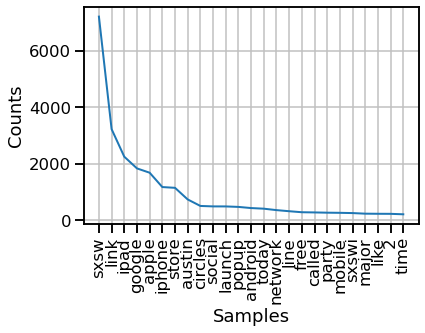

In [43]:
freq_train.plot(25);

In [44]:
# we see that there are words in there that arnt helpful like , and 2
# in response Im going to get rid of all words 2 or shorter characters



In [45]:
# now combine all to do for X_test

shortword = re.compile(r'\W*\b\w{1,3}\b')

def cleaner(tweet):
    
    tweet = re.sub(r'@[A-Za-z0-9]+','', str(tweet)) # removes @
    tweet = re.sub(r'#', '', str(tweet)) # removes hashtag
    tweet = re.sub(r'RT[\s]+','', str(tweet)) # removes RT
    tweet = re.sub(r'https?:\/\/\S+', '', tweet) # remove hyperlink in tweet
    tweet = re.sub(r'[^\w\s]', '', tweet) # removes punctuations
    tweet = re.sub(r',', '', str(tweet)) # remove commas 
    tweet = shortword.sub('', tweet)
    tweet = X_test["tweet_text"].str.lower()
    
    return tweet

X_test["tweet_text"] = X_test["tweet_text"].apply(cleaner)





In [46]:
# Create new column with tokenized data
X_test['clean_tweet'] = X_test["tweet_text"].apply(tokenizer.tokenize)
# Display full text
X_train

# make clean tweets a text blob instead of list 
X_test['clean_tweet']=[" ".join(cleantweet) for cleantweet in X_test['clean_tweet'].values]

In [47]:
# make clean tweets a text blob instead of list 
X_test['clean_tweet']=[" ".join(cleantweet) for cleantweet in X_test['clean_tweet'].values]

## Create a variable "corpus" containing all text
corpus_X_test = X_test['clean_tweet'].to_list()

## Convert Corpus to Tokens
tokens_test = word_tokenize(','.join(corpus_X_train))

#tokens_train.remove(',')
tokens_test = [x for x in tokens_test if x != ',']

## Get FreqDist 
freq_test = FreqDist(tokens_test)

freq_test.most_common(10)

[('sxsw', 7221),
 ('link', 3229),
 ('ipad', 2251),
 ('google', 1836),
 ('apple', 1683),
 ('iphone', 1174),
 ('store', 1147),
 ('austin', 735),
 ('circles', 504),
 ('social', 488)]

In [48]:
# need to add visualization

In [49]:
# Import 
from sklearn.feature_extraction.text import TfidfVectorizer
#df['Reviews']=[" ".join(review) for review in df['Reviews'].values]
# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(min_df = 2, max_df=.90)

# Fit the vectorizer on X_train["text"] and transform it
X_train_tfidf = tfidf.fit_transform(X_train['clean_tweet'])


# Fit the vectorizer on X_train["text"] and transform it
X_test_tfidf = tfidf.transform(X_test['clean_tweet']) 


# Visually inspect the vectorized train data
pd.DataFrame.sparse.from_spmatrix(X_train_tfidf, columns=tfidf.get_feature_names())

,0011,0311,0312,0313,0314,0315,03mzb,1000,100s,1030,...,zynga,û_time,ûªll,ûªre,ûïbest,ûïcheckin,ûïcoming,ûïthe,ûïwin,ûòand
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# Visually inspect the vectorized train data
pd.DataFrame.sparse.from_spmatrix(X_test_tfidf, columns=tfidf.get_feature_names())

,0011,0311,0312,0313,0314,0315,03mzb,1000,100s,1030,...,zynga,û_time,ûªll,ûªre,ûïbest,ûïcheckin,ûïcoming,ûïthe,ûïwin,ûòand
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling

### Baseline model: RandomForest

In [51]:
# we know that the data is not balenced so we will need to deal with that first
from sklearn.metrics import plot_confusion_matrix

# make function to view model performance 
from sklearn import metrics
def model_eval(model, X_test_tfidf, y_test,
               normalize='true', return_fig=False,
               classes=None, figsize=(14, 6)):
    # Get Predictions
    y_hat_train = model.predict(X_train_tfidf)
    print('Classification Report for Training Set')
    print(metrics.classification_report(y_train, y_hat_train, target_names=classes))
    
    print('Classification Report for Testing Set')
    y_hat_test = model.predict(X_test_tfidf)
    print(metrics.classification_report(y_test, y_hat_test, target_names=classes))
    
    
    print("-------------")
    
    
    plot_confusion_matrix(model,X_test_tfidf,y_test, cmap='Blues', display_labels=classes);

    if return_fig:
        return fig,axes

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.94      0.98      0.96      4158
   Postitive       0.97      0.92      0.94       427
    Negative       0.97      0.90      0.93      2234

    accuracy                           0.95      6819
   macro avg       0.96      0.93      0.95      6819
weighted avg       0.95      0.95      0.95      6819

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.61      1.00      0.76      1386
   Postitive       0.00      0.00      0.00       143
    Negative       0.00      0.00      0.00       744

    accuracy                           0.61      2273
   macro avg       0.20      0.33      0.25      2273
weighted avg       0.37      0.61      0.46      2273

-------------


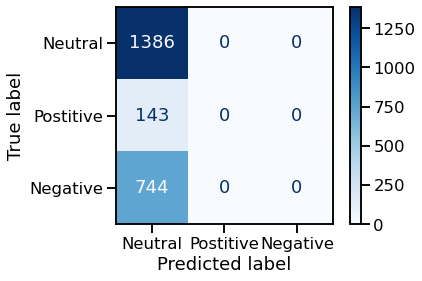

In [52]:

# set the fuction to the tree baseline model
rf_base = RandomForestClassifier()
model = rf_base.fit(X_train_tfidf,y_train)

model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);

This model was horrible on testing data. A likely reason for this is that the data is very imbalanced, almost all the tweets have no emotion. The first step in improving the model would be to work on the imbalanced issue. We will start with SMOTE and see how that improves the model 

In [53]:
from imblearn.over_sampling import SMOTE

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train_tfidf, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 



2    4158
1    4158
0    4158
Name: target, dtype: int64


In [54]:
# we know that the data is not balanced so we will need to deal with that first

# make function to view model performance 
from sklearn import metrics
def model_eval(model, X_test_tfidf, y_test,
               normalize='true', return_fig=False,
               classes=None, figsize=(14, 6)):
    # Get Predictions
    y_hat_train = model.predict(X_train_resampled)
    print('Classification Report for Training Set')
    print(metrics.classification_report(y_train_resampled, y_hat_train, target_names=classes))
    
    print('Classification Report for Testing Set')
    y_hat_test = model.predict(X_test_tfidf)
    print(metrics.classification_report(y_test, y_hat_test, target_names=classes))
    
    
    print("-------------")
    
    
    plot_confusion_matrix(model,X_test_tfidf,y_test, cmap='Blues', display_labels=classes);

    if return_fig:
        return fig,axes

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.95      0.97      0.96      4158
   Postitive       0.99      0.99      0.99      4158
    Negative       0.97      0.95      0.96      4158

    accuracy                           0.97     12474
   macro avg       0.97      0.97      0.97     12474
weighted avg       0.97      0.97      0.97     12474

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.61      1.00      0.76      1386
   Postitive       0.00      0.00      0.00       143
    Negative       0.00      0.00      0.00       744

    accuracy                           0.61      2273
   macro avg       0.20      0.33      0.25      2273
weighted avg       0.37      0.61      0.46      2273

-------------


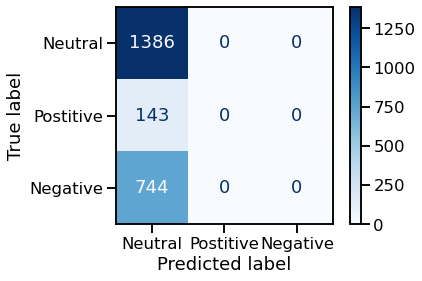

In [55]:
model = RandomForestClassifier()

model.fit(X_train_resampled, y_train_resampled)

model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);

In [56]:
print('\n')
print(pd.Series(y_train).value_counts()) 



0    4158
2    2234
1     427
Name: target, dtype: int64


In [57]:
# try to improve RandomForest with param
# set parameters and grid search

param = {'criterion': ['gini', 'entropy'],
         'n_estimators':[50,100,200],
         'min_samples_split': [5, 10, 20],
         'min_samples_leaf': [3, 6, 15]
    
}

gridsearch = GridSearchCV(estimator=model,
                          param_grid=param)

#Run search & takes a min or two
gridsearch.fit(X_train_resampled, y_train_resampled)
gridsearch.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 200}

In [59]:
param = {'criterion': ['gini'],
         'n_estimators':[170, 200, 250],
         'min_samples_split': [8, 10, 15],
         'min_samples_leaf': [2, 3, 4]
    
}

gridsearch = GridSearchCV(estimator=model,
                          param_grid=param)

#Run search & takes a min or two
gridsearch.fit(X_train_resampled, y_train_resampled)
gridsearch.best_params_

KeyboardInterrupt: 

In [ ]:
param = {'criterion': ['gini'],
         'n_estimators':[250, 300, 450],
         'min_samples_split': [10],
         'min_samples_leaf': [2]
    
}

gridsearch = GridSearchCV(estimator=model,
                          param_grid=param)

#Run search & takes a min or two
gridsearch.fit(X_train_resampled, y_train_resampled)
gridsearch.best_params_

In [ ]:
params = gridsearch.best_params_
model = RandomForestClassifier(**params)
model.fit(X_train_resampled, y_train_resampled)
model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);

The random forest model is not doing great. Next lets try a different type of model to see if that will imporve our scores.

In [ ]:
# Import functions needed
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Set a C value, this tells the model how to choose the parameters & how much 
# weight to but on the training data a low C will be a more complex model but risks over fitting 
Model = LogisticRegression(max_iter=5000, C=1e12)
model.fit(X_train_resampled, y_train_resampled)
model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);

In [ ]:
# Set a C value, this tells the model how to choose the parameters & how much 
# weight to but on the training data a low C will be a more complex model but risks over fitting 
Model = LogisticRegression(max_iter=5000, C=1e12)
model.fit(X_train_tfidf, y_train)
model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);